Fivethirtyeight.com has opened its prediction data for everyone. Their NFL
probabilistic predictions can be found here:
https://projects.fivethirtyeight.com/nfl-api/nfl_elo.csv
Calculate the Brier score, the accuracy (assuming a win probability threshold
of 0.5) and the reliability curve for the predictions for the NFL seasons
between 2010-2018. For the Brier score decompose it to its 3 parts (30
points).
Note: In order to get the full points you need to write your own code for
calculating the above metrics, i.e., do not rely on an already existing function
in any programming language, which you should submit as part of your
solution.

In [2]:
#load tools
import pandas as pd
import numpy as np
import seaborn as snas
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


Side note: I actually have no idea how football works (I know that you throw a ball and there are two teams and there's a quarterback), so I looked up and tried reading up on what all these categories were. My understanding is that I am taking the elo_prob1 and elo_prob2 to try to predict the outcome of the game, and then checking it against score1 and score2.

In [3]:
#load file
df = pd.read_csv("https://projects.fivethirtyeight.com/nfl-api/nfl_elo.csv")
df

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2
0,1920-09-26,1920,0,NaN,RII,STP,1503.947,1300.000,0.824651,0.175349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,0.0
1,1920-10-03,1920,0,NaN,RCH,ABU,1503.420,1300.000,0.824212,0.175788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.0
2,1920-10-03,1920,0,NaN,DAY,COL,1493.002,1504.908,0.575819,0.424181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0.0
3,1920-10-03,1920,0,NaN,RII,MUN,1516.108,1478.004,0.644171,0.355829,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,0.0
4,1920-10-03,1920,0,NaN,CHI,MUT,1368.333,1300.000,0.682986,0.317014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16805,2021-01-17,2020,0,d,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16806,2021-01-17,2020,0,d,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16807,2021-01-24,2020,0,c,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16808,2021-01-24,2020,0,c,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#for the sake of clarity, I'm going to drop the columns that I won't be using
df.drop(df.iloc[:,0:4], axis = 'columns', inplace = True)
df.drop(df.iloc[:,2:4], axis = 'columns', inplace = True)
df.drop(df.iloc[:,4:-2], axis = 'columns', inplace = True)
df

,team1,team2,elo_prob1,elo_prob2,score1,score2
0,RII,STP,0.824651,0.175349,48.0,0.0
1,RCH,ABU,0.824212,0.175788,10.0,0.0
2,DAY,COL,0.575819,0.424181,14.0,0.0
3,RII,MUN,0.644171,0.355829,45.0,0.0
4,CHI,MUT,0.682986,0.317014,20.0,0.0
...,...,...,...,...,...,...
16805,NaN,NaN,NaN,NaN,NaN,NaN
16806,NaN,NaN,NaN,NaN,NaN,NaN
16807,NaN,NaN,NaN,NaN,NaN,NaN
16808,NaN,NaN,NaN,NaN,NaN,NaN


Even just from the preview, we can see that there are tons of null values. In this case, I will drop the null elo values, since it is not possible to have no elo and it is risky to just assume the elo. In addition, null values in the the score columns will be dropped since that might mean that the games have not been played yet, and it is incorrect to juust assume scores. 

In [5]:
df.isnull().sum()

team1         13
team2         13
elo_prob1     13
elo_prob2     13
score1       253
score2       253
dtype: int64

In [6]:
#drop the null rows and reindex in case it is not in order
df = df.dropna()
df.reset_index(drop=True, inplace=True)
df

,team1,team2,elo_prob1,elo_prob2,score1,score2
0,RII,STP,0.824651,0.175349,48.0,0.0
1,RCH,ABU,0.824212,0.175788,10.0,0.0
2,DAY,COL,0.575819,0.424181,14.0,0.0
3,RII,MUN,0.644171,0.355829,45.0,0.0
4,CHI,MUT,0.682986,0.317014,20.0,0.0
...,...,...,...,...,...,...
16552,SF,ARI,0.786127,0.213873,20.0,24.0
16553,NO,TB,0.733832,0.266168,34.0,23.0
16554,LAR,DAL,0.614663,0.385337,20.0,17.0
16555,NYG,PIT,0.420617,0.579383,16.0,26.0


BS = uncertainty + reliability - resolution

In [69]:
#brier score pt 1
#uncertainty = base.rate * (1 - base.rate)
df['uncertainty'] = df.elo_prob1 * (1 - df.elo_prob2)
unc = (df['uncertainty'].mean())
df

/Users/dragon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,team1,team2,elo_prob1,elo_prob2,score1,score2,uncertainty
0,RII,STP,0.824651,0.175349,48.0,0.0,0.680050
1,RCH,ABU,0.824212,0.175788,10.0,0.0,0.679326
2,DAY,COL,0.575819,0.424181,14.0,0.0,0.331568
3,RII,MUN,0.644171,0.355829,45.0,0.0,0.414956
4,CHI,MUT,0.682986,0.317014,20.0,0.0,0.466469
...,...,...,...,...,...,...,...
16552,SF,ARI,0.786127,0.213873,20.0,24.0,0.617996
16553,NO,TB,0.733832,0.266168,34.0,23.0,0.538510
16554,LAR,DAL,0.614663,0.385337,20.0,17.0,0.377811
16555,NYG,PIT,0.420617,0.579383,16.0,26.0,0.176918


Resolution

In [8]:
#brier score pt 2
#so resolution demands that we look at the probability vs the actual thing
#for my sanity, I'm going to do this the long way individually
ninety = pd.DataFrame()
ninety = df[df['elo_prob1'] > 0.9]
ninety.reset_index(drop=True, inplace=True)
ninety

#ninety.loc[((ninety['elo_prob1'] >= ninety['elo_prob2']) & (ninety['score1'] <= ninety['score2']))]

,team1,team2,elo_prob1,elo_prob2,score1,score2,uncertainty
0,CHI,OOR,0.918846,0.081154,33.0,6.0,0.844278
1,BFF,OOR,0.900723,0.099277,7.0,19.0,0.811303
2,CBD,MIL,0.913284,0.086716,40.0,6.0,0.834088
3,CBD,OOR,0.941993,0.058007,41.0,0.0,0.887351
4,PTB,BRL,0.911038,0.088962,14.0,0.0,0.829990
...,...,...,...,...,...,...,...
204,NE,NYJ,0.907280,0.092720,26.0,6.0,0.823157
205,PIT,CLE,0.953944,0.046056,28.0,24.0,0.910009
206,NE,NYJ,0.907637,0.092363,30.0,14.0,0.823805
207,BAL,NYJ,0.917435,0.082565,42.0,21.0,0.841687


In [9]:
#fifteen teams were predicted to win in the 90% bin, but instead lost
nine_predict = (208-15)/208
ninety['nine_diff'] = nine_predict - ninety.elo_prob1
ninety

/Users/dragon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,team1,team2,elo_prob1,elo_prob2,score1,score2,uncertainty,nine_diff
0,CHI,OOR,0.918846,0.081154,33.0,6.0,0.844278,0.009039
1,BFF,OOR,0.900723,0.099277,7.0,19.0,0.811303,0.027161
2,CBD,MIL,0.913284,0.086716,40.0,6.0,0.834088,0.014600
3,CBD,OOR,0.941993,0.058007,41.0,0.0,0.887351,-0.014109
4,PTB,BRL,0.911038,0.088962,14.0,0.0,0.829990,0.016847
...,...,...,...,...,...,...,...,...
204,NE,NYJ,0.907280,0.092720,26.0,6.0,0.823157,0.020605
205,PIT,CLE,0.953944,0.046056,28.0,24.0,0.910009,-0.026059
206,NE,NYJ,0.907637,0.092363,30.0,14.0,0.823805,0.020247
207,BAL,NYJ,0.917435,0.082565,42.0,21.0,0.841687,0.010449


In [10]:
#to find the resolution, square the diffs and multiply them by the number of forecasts
ninety['ninety_res'] = 208 * (ninety.nine_diff**2)
ninety

/Users/dragon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,team1,team2,elo_prob1,elo_prob2,score1,score2,uncertainty,nine_diff,ninety_res
0,CHI,OOR,0.918846,0.081154,33.0,6.0,0.844278,0.009039,0.016993
1,BFF,OOR,0.900723,0.099277,7.0,19.0,0.811303,0.027161,0.153447
2,CBD,MIL,0.913284,0.086716,40.0,6.0,0.834088,0.014600,0.044340
3,CBD,OOR,0.941993,0.058007,41.0,0.0,0.887351,-0.014109,0.041404
4,PTB,BRL,0.911038,0.088962,14.0,0.0,0.829990,0.016847,0.059031
...,...,...,...,...,...,...,...,...,...
204,NE,NYJ,0.907280,0.092720,26.0,6.0,0.823157,0.020605,0.088308
205,PIT,CLE,0.953944,0.046056,28.0,24.0,0.910009,-0.026059,0.141250
206,NE,NYJ,0.907637,0.092363,30.0,14.0,0.823805,0.020247,0.085271
207,BAL,NYJ,0.917435,0.082565,42.0,21.0,0.841687,0.010449,0.022711


Now the same thing needs to be done with the other bins

In [11]:
eighty = pd.DataFrame()
eighty = df[df['elo_prob1'] > 0.8]
eighty = eighty[eighty['elo_prob1'] < 0.9]
eighty.reset_index(drop=True, inplace=True)
eighty

#eighty.loc[((eighty['elo_prob1'] >= eighty['elo_prob2']) & (eighty['score1'] <= eighty['score2']))]

#272 teams were predicted to win but instead lost
eight_predict = (1667-272)/1667
eighty['eight_diff'] = eight_predict - eighty.elo_prob1
eighty

eighty['eighty_res'] = 1667 * (eighty.eight_diff**2)
eighty

,team1,team2,elo_prob1,elo_prob2,score1,score2,uncertainty,eight_diff,eighty_res
0,RII,STP,0.824651,0.175349,48.0,0.0,0.680050,0.012181,0.247362
1,RCH,ABU,0.824212,0.175788,10.0,0.0,0.679326,0.012621,0.265516
2,CBD,PTQ,0.825267,0.174733,48.0,0.0,0.681066,0.011565,0.222979
3,BFF,WBU,0.802000,0.198000,32.0,6.0,0.643204,0.034832,2.022557
4,AKR,WHE,0.824212,0.175788,43.0,0.0,0.679326,0.012621,0.265516
...,...,...,...,...,...,...,...,...,...
1663,SEA,ARI,0.866872,0.133128,13.0,27.0,0.751466,-0.030039,1.504199
1664,KC,LAC,0.843997,0.156003,31.0,21.0,0.712331,-0.007165,0.085571
1665,DAL,WSH,0.842364,0.157636,47.0,16.0,0.709577,-0.005531,0.051004
1666,BAL,PIT,0.838269,0.161731,28.0,10.0,0.702695,-0.001436,0.003439


In [12]:
seventy = pd.DataFrame()
seventy = df[df['elo_prob1'] > 0.7]
seventy = seventy[seventy['elo_prob1'] < 0.8]
seventy.reset_index(drop=True, inplace=True)
seventy

#seventy.loc[((seventy['elo_prob1'] >= seventy['elo_prob2']) & (seventy['score1'] <= seventy['score2']))].count()

#799 teams were predicted to win but instead lost
seventy_predict = (2908-799)/2908
seventy['seventy_diff'] = seventy_predict - seventy.elo_prob1
seventy

seventy['seventy_res'] = 2908 * (seventy.seventy_diff**2)
seventy


,team1,team2,elo_prob1,elo_prob2,score1,score2,uncertainty,seventy_diff,seventy_res
0,RII,HAM,0.718613,0.281387,26.0,0.0,0.516404,0.006628,0.127757
1,CHI,KEW,0.705223,0.294777,25.0,7.0,0.497339,0.020018,1.165282
2,RII,CHI,0.781736,0.218264,0.0,7.0,0.611111,-0.056495,9.281449
3,DAY,HAM,0.701625,0.298375,44.0,0.0,0.492278,0.023616,1.621806
4,AKR,CTI,0.710452,0.289548,7.0,0.0,0.504743,0.014788,0.635964
...,...,...,...,...,...,...,...,...,...
2904,KC,HOU,0.767256,0.232744,51.0,31.0,0.588682,-0.042016,5.133554
2905,KC,HOU,0.761756,0.238244,34.0,20.0,0.580272,-0.036515,3.877348
2906,NE,MIA,0.792329,0.207671,21.0,11.0,0.627785,-0.067088,13.088394
2907,SF,ARI,0.786127,0.213873,20.0,24.0,0.617996,-0.060887,10.780479


In [13]:
sixty = pd.DataFrame()
sixty = df[df['elo_prob1'] > 0.6]
sixty = sixty[sixty['elo_prob1'] < 0.7]
sixty.reset_index(drop=True, inplace=True)
sixty

#sixty.loc[((sixty['elo_prob1'] >= sixty['elo_prob2']) & (sixty['score1'] <= sixty['score2']))].count()

#1235 teams were predicted to win but instead lost
sixty_predict = (3383-1235)/3383
sixty['sixty_diff'] = sixty_predict - sixty.elo_prob1
sixty

sixty['sixty_res'] = 3383 * (sixty.sixty_diff**2)
sixty

,team1,team2,elo_prob1,elo_prob2,score1,score2,uncertainty,sixty_diff,sixty_res
0,RII,MUN,0.644171,0.355829,45.0,0.0,0.414956,-0.009232,0.288313
1,CHI,MUT,0.682986,0.317014,20.0,0.0,0.466469,-0.048046,7.809433
2,AKR,COL,0.637146,0.362854,37.0,0.0,0.405955,-0.002207,0.016476
3,DAY,CTI,0.660906,0.339094,0.0,0.0,0.436797,-0.025967,2.281073
4,CBD,CTI,0.670459,0.329541,7.0,0.0,0.449515,-0.035519,4.268101
...,...,...,...,...,...,...,...,...,...
3379,GB,SEA,0.662990,0.337010,28.0,23.0,0.439555,-0.028050,2.661824
3380,KC,TEN,0.653145,0.346855,35.0,24.0,0.426598,-0.018206,1.121267
3381,SF,GB,0.604293,0.395707,37.0,20.0,0.365170,0.030646,3.177242
3382,BUF,NYJ,0.663948,0.336052,27.0,17.0,0.440828,-0.029009,2.846879


In [14]:
fifty = pd.DataFrame()
fifty = df[df['elo_prob1'] > 0.5]
fifty = fifty[fifty['elo_prob1'] < 0.6]
fifty.reset_index(drop=True, inplace=True)
fifty

#fifty.loc[((fifty['elo_prob1'] >= fifty['elo_prob2']) & (fifty['score1'] <= fifty['score2']))].count()

#1235 teams were predicted to win but instead lost
fifty_predict = (3174-1446)/3174
fifty['fifty_diff'] = fifty_predict - fifty.elo_prob1
fifty

fifty['fifty_res'] = 3174 * (fifty.fifty_diff**2)
fifty

,team1,team2,elo_prob1,elo_prob2,score1,score2,uncertainty,fifty_diff,fifty_res
0,DAY,COL,0.575819,0.424181,14.0,0.0,0.331568,-0.031396,3.128577
1,DAY,CBD,0.579942,0.420058,20.0,20.0,0.336333,-0.035518,4.004179
2,CBD,AKR,0.570910,0.429090,0.0,10.0,0.325939,-0.026487,2.226752
3,ARI,DHR,0.590309,0.409691,21.0,0.0,0.348464,-0.045885,6.682730
4,BFF,RCH,0.594313,0.405687,17.0,6.0,0.353209,-0.049890,7.900136
...,...,...,...,...,...,...,...,...,...
3169,KC,SF,0.571370,0.428630,31.0,20.0,0.326464,-0.026947,2.304776
3170,CAR,OAK,0.564980,0.435020,30.0,34.0,0.319202,-0.020556,1.341229
3171,MIN,GB,0.576645,0.423355,34.0,43.0,0.332519,-0.032221,3.295306
3172,ATL,SEA,0.575148,0.424852,25.0,38.0,0.330795,-0.030724,2.996174


In [15]:
forty = pd.DataFrame()
forty = df[df['elo_prob1'] > 0.4]
forty = forty[forty['elo_prob1'] < 0.5]
forty.reset_index(drop=True, inplace=True)
forty

#forty.loc[((forty['elo_prob1'] <= forty['elo_prob2']) & (forty['score1'] >= forty['score2']))].count()

#1108 teams were predicted to lose but instead won
forty_predict = (1108)/2435
forty['forty_diff'] = forty_predict - forty.elo_prob1
forty

forty['forty_res'] = 2435 * (forty.forty_diff**2)
forty

,team1,team2,elo_prob1,elo_prob2,score1,score2,uncertainty,forty_diff,forty_res
0,CHT,CHI,0.455939,0.544061,0.0,10.0,0.207881,-0.000909,0.002011
1,LOG,HAM,0.441680,0.558320,9.0,14.0,0.195081,0.013351,0.434007
2,PUL,HAM,0.419750,0.580250,13.0,14.0,0.176190,0.035281,3.030983
3,ZAN,COL,0.457209,0.542791,0.0,10.0,0.209040,-0.002178,0.011555
4,GAR,HAM,0.411816,0.588184,7.0,6.0,0.169592,0.043215,4.547410
...,...,...,...,...,...,...,...,...,...
2431,CHI,KC,0.424391,0.575609,3.0,26.0,0.180108,0.030640,2.285930
2432,DET,CHI,0.421509,0.578491,23.0,27.0,0.177670,0.033522,2.736193
2433,CIN,LAC,0.467288,0.532712,13.0,16.0,0.218358,-0.012257,0.365845
2434,NYG,PIT,0.420617,0.579383,16.0,26.0,0.176918,0.034414,2.883853


In [16]:
thirty = pd.DataFrame()
thirty = df[df['elo_prob1'] > 0.3]
thirty = thirty[thirty['elo_prob1'] < 0.4]
thirty.reset_index(drop=True, inplace=True)
thirty

#thirty.loc[((thirty['elo_prob1'] <= thirty['elo_prob2']) & (thirty['score1'] >= thirty['score2']))].count()

#597 teams were predicted to lose but instead won
thirty_predict = (597)/1662
thirty['thirty_diff'] = thirty_predict - thirty.elo_prob1
thirty

thirty['thirty_res'] = 1662 * (thirty.thirty_diff**2)
thirty

,team1,team2,elo_prob1,elo_prob2,score1,score2,uncertainty,thirty_diff,thirty_res
0,CHT,ARI,0.323696,0.676304,0.0,0.0,0.104779,0.035510,2.095712
1,CHT,DHR,0.308986,0.691014,12.0,0.0,0.095473,0.050220,4.191562
2,FTW,COL,0.370343,0.629657,14.0,0.0,0.137154,-0.011137,0.206149
3,RCK,CHI,0.365935,0.634065,0.0,29.0,0.133908,-0.006729,0.075257
4,CHT,ARI,0.322418,0.677582,3.0,6.0,0.103953,0.036788,2.249247
...,...,...,...,...,...,...,...,...,...
1658,NYJ,PIT,0.340813,0.659187,16.0,10.0,0.116153,0.018393,0.562252
1659,CIN,CLE,0.382154,0.617846,33.0,23.0,0.146041,-0.022948,0.875225
1660,NYG,PHI,0.314850,0.685150,17.0,34.0,0.099131,0.044356,3.269855
1661,JAX,IND,0.393444,0.606556,38.0,20.0,0.154798,-0.034238,1.948301


In [17]:
twenty = pd.DataFrame()
twenty = df[df['elo_prob1'] > 0.2]
twenty = twenty[twenty['elo_prob1'] < 0.3]
twenty.reset_index(drop=True, inplace=True)
twenty

#twenty.loc[((twenty['elo_prob1'] <= twenty['elo_prob2']) & (twenty['score1'] >= twenty['score2']))].count()

#234 teams were predicted to lose but instead won
twenty_predict = (234)/880
twenty['twenty_diff'] = twenty_predict - twenty.elo_prob1
twenty

twenty['twenty_res'] = 880 * (twenty.twenty_diff**2)
twenty

,team1,team2,elo_prob1,elo_prob2,score1,score2,uncertainty,twenty_diff,twenty_res
0,THO,RII,0.266847,0.733153,7.0,7.0,0.071207,-0.000938,0.000774
1,CHT,CHI,0.272963,0.727037,0.0,6.0,0.074509,-0.007054,0.043788
2,WGC,CBD,0.262943,0.737057,0.0,0.0,0.069139,0.002966,0.007743
3,UAP,CBD,0.271088,0.728912,13.0,7.0,0.073489,-0.005179,0.023602
4,DTI,DAY,0.269537,0.730463,10.0,7.0,0.072650,-0.003628,0.011582
...,...,...,...,...,...,...,...,...,...
876,NYG,GB,0.279728,0.720272,13.0,31.0,0.078248,-0.013819,0.168051
877,ARI,PIT,0.280992,0.719008,17.0,23.0,0.078956,-0.015082,0.200183
878,CLE,BAL,0.222585,0.777415,15.0,31.0,0.049544,0.043324,1.651723
879,DET,GB,0.239927,0.760073,20.0,23.0,0.057565,0.025983,0.594081


In [18]:
ten = pd.DataFrame()
ten = df[df['elo_prob1'] > 0.1]
ten = ten[ten['elo_prob1'] < 0.2]
ten.reset_index(drop=True, inplace=True)
ten

#ten.loc[((ten['elo_prob1'] <= ten['elo_prob2']) & (ten['score1'] >= ten['score2']))].count()

#38 teams were predicted to lose but instead won
ten_predict = (38)/228
ten['ten_diff'] = ten_predict - ten.elo_prob1
ten

ten['ten_res'] = 228 * (ten.ten_diff**2)
ten

,team1,team2,elo_prob1,elo_prob2,score1,score2,uncertainty,ten_diff,ten_res
0,DTI,AKR,0.183554,0.816446,0.0,20.0,0.033692,-0.016888,0.065024
1,COL,AKR,0.174466,0.825534,0.0,21.0,0.030438,-0.007799,0.013868
2,CIB,CBD,0.178146,0.821854,10.0,46.0,0.031736,-0.011479,0.030042
3,BRL,PTB,0.188851,0.811149,0.0,21.0,0.035665,-0.022184,0.112205
4,MNN,GB,0.175189,0.824811,6.0,16.0,0.030691,-0.008522,0.016560
...,...,...,...,...,...,...,...,...,...
224,OAK,KC,0.171749,0.828251,33.0,40.0,0.029498,-0.005083,0.005890
225,WSH,NE,0.183983,0.816017,7.0,33.0,0.033850,-0.017316,0.068364
226,NYJ,NE,0.153361,0.846639,0.0,33.0,0.023519,0.013306,0.040368
227,CIN,BAL,0.184085,0.815915,13.0,49.0,0.033887,-0.017419,0.069178


In [64]:
#the inverse of the number_predict values can be used for elo_prob2 diffs if needed
#to properly calculate resolution, all the bins must be added
print('Resolution =')
res = (ninety['ninety_res'].mean()+eighty['eighty_res'].mean()+seventy['seventy_res'].mean()+sixty['sixty_res'].mean()+fifty['fifty_res'].mean()+forty['forty_res'].mean()+thirty['thirty_res'].mean()+twenty['twenty_res'].mean()+ten['ten_res'].mean())/16556
res

Resolution =


0.0009710163919546032

Reliability

In [48]:
#calculate the diff between average bin predicted prob and bin base rate
avg_nine = ninety['elo_prob1'].mean()
avg_nine_diff = ninety['nine_diff'].mean()
bin9 = ((avg_nine-avg_nine_diff)**2)*208

avg_eight = eighty['elo_prob1'].mean()
avg_eight_diff = eighty['eight_diff'].mean()
bin8 = ((avg_eight-avg_eight_diff)**2)*1667

avg_seven = seventy['elo_prob1'].mean()
avg_seven_diff = seventy['seventy_diff'].mean()
bin7 = ((avg_seven-avg_seven_diff)**2)*2908

avg_six = sixty['elo_prob1'].mean()
avg_six_diff = sixty['sixty_diff'].mean()
bin6 = ((avg_six-avg_six_diff)**2)*3383

avg_fif = fifty['elo_prob1'].mean()
avg_fif_diff = fifty['fifty_diff'].mean()
bin5 = ((avg_fif-avg_fif_diff)**2)*3174

avg_for = forty['elo_prob1'].mean()
avg_for_diff = forty['forty_diff'].mean()
bin4 = ((avg_for-avg_for_diff)**2)*2435

avg_thir = thirty['elo_prob1'].mean()
avg_thir_diff = thirty['thirty_diff'].mean()
bin3 = ((avg_thir-avg_thir_diff)**2)*1662

avg_twen = twenty['elo_prob1'].mean()
avg_twen_diff = twenty['twenty_diff'].mean()
bin2 = ((avg_twen-avg_twen_diff)**2)*880

avg_ten = ten['elo_prob1'].mean()
avg_ten_diff = ten['ten_diff'].mean()
bin1 = ((avg_ten-avg_ten_diff)**2)*228

reli = (bin9+bin8+bin7+bin6+bin5+bin4+bin3+bin2+bin1)/16556
reli
#....I followed the example in the powerpoint to the best of my ability, but 
# the example didnt include that the end result has to be divided by N, which confused me 
# a lot when I got a huge number from the sum

0.3834783112941107

In [70]:
#accuracy
#BSS = -(resolution-reliability)/uncertainty
BSS = -(res-reli)/unc
BSS

1.0260851398726327

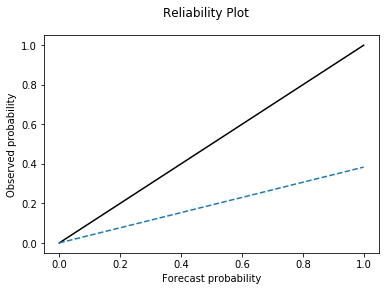

In [81]:
#reliability curve
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
ax.add_line(line)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = 0 + (reli) * x_vals
plt.plot(x_vals, y_vals, '--')
fig.suptitle('Reliability Plot')
ax.set_xlabel('Forecast probability')
ax.set_ylabel('Observed probability')
plt.show()